In [18]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('../data_type.csv', parse_dates=['date'])
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

In [5]:
df1.index[0].strftime('%A'), df2.index[0].strftime('%A'), df3.index[0].strftime('%A')

('Sunday', 'Tuesday', 'Friday')

In [6]:
df1.index[-1].strftime('%A'), df2.index[-1].strftime('%A'), df3.index[-1].strftime('%A')

('Thursday', 'Saturday', 'Tuesday')

### Create batches of training data (12 months)

In [7]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit MLP model 

In [8]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=100)
    model = Sequential()
    model.add(Dense(500, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, verbose=1, callbacks=[callback])
    return model 

In [9]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    model = fit(X, y, n_input, n_output)
    
    x_input = dataset[-n_steps_in:]
    x_input = x_input.reshape((1, n_input, 1))
    pred = model.predict(x_input)
    
    mae, rmse, mape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, mape_aux = measure_error(actual, pred[0], n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), mape.append(mape_aux)
        #print(actual[i:i+n_steps_in], pred[0], mae, rmse, mape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        current_pred = model.predict(x_input)
    
    return mae, rmse, mape

In [10]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [11]:
def measure_error(actual, pred, step, index):
    #print(actual[index:index+step], pred)
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [12]:
df1 = df1.pivot_table('count', 'date', 'type')
df1['Total'] = df1.sum(axis=1)
dataset = df1[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].values
dataset_total = df1[['Total']].values
mae1, rmse1, smape1 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df1[['Total']][509:].values)

Epoch 1/500


2022-10-08 15:12:16.566297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-08 15:12:16.566330: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-08 15:12:16.566357: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-08 15:12:16.566564: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16/16 [==============================] - 1s 5ms/step - loss: 366550.0938
Epoch 2/500
16/16 [==============================] - 0s 7ms/step - loss: 26905.9961
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 12055.5859
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 7272.0024
Epoch 5/500
16/16 [==============================] - 0s 4ms/step - loss: 6308.0088
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 6193.0459
Epoch 7/500
16/16 [==============================] - 0s 3ms/step - loss: 6562.5845
Epoch 8/500
16/16 [==============================] - 0s 4ms/step - loss: 6273.8184
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 5992.2983
Epoch 10/500
16/16 [==============================] - 0s 4ms/step - loss: 5931.9136
Epoch 11/500
16/16 [==============================] - 0s 3ms/step - loss: 5921.4185
Epoch 12/500
16/16 [==============================] - 0s 4ms/step - loss: 5932.1714
Epoch 13/

16/16 [==============================] - 0s 5ms/step - loss: 4957.6538
Epoch 99/500
16/16 [==============================] - 0s 5ms/step - loss: 5003.2939
Epoch 100/500
16/16 [==============================] - 0s 4ms/step - loss: 5309.7920
Epoch 101/500
16/16 [==============================] - 0s 4ms/step - loss: 5129.6548
Epoch 102/500
16/16 [==============================] - 0s 5ms/step - loss: 4995.5972
Epoch 103/500
16/16 [==============================] - 0s 4ms/step - loss: 4918.6421
Epoch 104/500
16/16 [==============================] - 0s 8ms/step - loss: 5119.1919
Epoch 105/500
16/16 [==============================] - 0s 7ms/step - loss: 5124.4136
Epoch 106/500
16/16 [==============================] - 0s 8ms/step - loss: 5010.4663
Epoch 107/500
16/16 [==============================] - 0s 8ms/step - loss: 4885.7373
Epoch 108/500
16/16 [==============================] - 0s 5ms/step - loss: 4947.7764
Epoch 109/500
16/16 [==============================] - 0s 5ms/step - loss: 4995.

16/16 [==============================] - 0s 8ms/step - loss: 4735.1055
Epoch 195/500
16/16 [==============================] - 0s 6ms/step - loss: 4778.0957
Epoch 196/500
16/16 [==============================] - 0s 7ms/step - loss: 4509.7085
Epoch 197/500
16/16 [==============================] - 0s 6ms/step - loss: 4704.2920
Epoch 198/500
16/16 [==============================] - 0s 6ms/step - loss: 4623.4224
Epoch 199/500
16/16 [==============================] - 0s 7ms/step - loss: 4811.3154
Epoch 200/500
16/16 [==============================] - 0s 6ms/step - loss: 4836.2861
Epoch 201/500
16/16 [==============================] - 0s 8ms/step - loss: 4692.6851
Epoch 202/500
16/16 [==============================] - 0s 7ms/step - loss: 4564.5552
Epoch 203/500
16/16 [==============================] - 0s 7ms/step - loss: 4861.8726
Epoch 204/500
16/16 [==============================] - 0s 6ms/step - loss: 4655.4102
Epoch 205/500
16/16 [==============================] - 0s 6ms/step - loss: 4728

16/16 [==============================] - 0s 9ms/step - loss: 4097.6465
Epoch 291/500
16/16 [==============================] - 0s 9ms/step - loss: 4366.2583
Epoch 292/500
16/16 [==============================] - 0s 9ms/step - loss: 4293.5308
Epoch 293/500
16/16 [==============================] - 0s 8ms/step - loss: 4689.1064
Epoch 294/500
16/16 [==============================] - 0s 10ms/step - loss: 4078.1204
Epoch 295/500
16/16 [==============================] - 0s 7ms/step - loss: 4152.3369
Epoch 296/500
16/16 [==============================] - 0s 9ms/step - loss: 4139.6709
Epoch 297/500
16/16 [==============================] - 0s 8ms/step - loss: 4395.6182
Epoch 298/500
16/16 [==============================] - 0s 8ms/step - loss: 3994.9346
Epoch 299/500
16/16 [==============================] - 0s 8ms/step - loss: 3919.1177
Epoch 300/500
16/16 [==============================] - 0s 8ms/step - loss: 3966.3713
Epoch 301/500
16/16 [==============================] - 0s 8ms/step - loss: 378

16/16 [==============================] - 0s 8ms/step - loss: 3640.4138
Epoch 387/500
16/16 [==============================] - 0s 9ms/step - loss: 3303.4075
Epoch 388/500
16/16 [==============================] - 0s 9ms/step - loss: 3351.5413
Epoch 389/500
16/16 [==============================] - 0s 8ms/step - loss: 3586.9692
Epoch 390/500
16/16 [==============================] - 0s 8ms/step - loss: 3532.8586
Epoch 391/500
16/16 [==============================] - 0s 8ms/step - loss: 3393.6409
Epoch 392/500
16/16 [==============================] - 0s 9ms/step - loss: 3623.3838
Epoch 393/500
16/16 [==============================] - 0s 8ms/step - loss: 3267.1296
Epoch 394/500
16/16 [==============================] - 0s 8ms/step - loss: 3458.4155
Epoch 395/500
16/16 [==============================] - 0s 8ms/step - loss: 3498.4360
Epoch 396/500
16/16 [==============================] - 0s 8ms/step - loss: 3435.4568
Epoch 397/500
16/16 [==============================] - 0s 9ms/step - loss: 3269

16/16 [==============================] - 0s 9ms/step - loss: 3025.9685
Epoch 483/500
16/16 [==============================] - 0s 7ms/step - loss: 3107.6260
Epoch 484/500
16/16 [==============================] - 0s 6ms/step - loss: 2958.5994
Epoch 485/500
16/16 [==============================] - 0s 6ms/step - loss: 2849.4673
Epoch 486/500
16/16 [==============================] - 0s 6ms/step - loss: 3003.9607
Epoch 487/500
16/16 [==============================] - 0s 7ms/step - loss: 3031.8396
Epoch 488/500
16/16 [==============================] - 0s 6ms/step - loss: 2803.7971
Epoch 489/500
16/16 [==============================] - 0s 6ms/step - loss: 2822.2805
Epoch 490/500
16/16 [==============================] - 0s 11ms/step - loss: 2784.0405
Epoch 491/500
16/16 [==============================] - 0s 9ms/step - loss: 2791.2175
Epoch 492/500
16/16 [==============================] - 0s 7ms/step - loss: 2997.6560
Epoch 493/500
16/16 [==============================] - 0s 5ms/step - loss: 285

In [13]:
df2 = df2.pivot_table('count', 'date', 'type')
df2['Total'] = df2.sum(axis=1)
dataset = df2[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].values
dataset_total = df2[['Total']].values
mae2, rmse2, smape2 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df2[['Total']][509:].values)

Epoch 1/500
16/16 [==============================] - 1s 8ms/step - loss: 425399.4688
Epoch 2/500
16/16 [==============================] - 0s 10ms/step - loss: 29045.9668
Epoch 3/500
16/16 [==============================] - 0s 8ms/step - loss: 11202.4814
Epoch 4/500
16/16 [==============================] - 0s 8ms/step - loss: 7016.0698
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 6235.4478
Epoch 6/500
16/16 [==============================] - 0s 5ms/step - loss: 6053.6030
Epoch 7/500
16/16 [==============================] - 0s 7ms/step - loss: 6047.5308
Epoch 8/500
16/16 [==============================] - 0s 6ms/step - loss: 5918.0449
Epoch 9/500
16/16 [==============================] - 0s 6ms/step - loss: 5930.6875
Epoch 10/500
16/16 [==============================] - 0s 6ms/step - loss: 5847.7651
Epoch 11/500
16/16 [==============================] - 0s 8ms/step - loss: 5957.0254
Epoch 12/500
16/16 [==============================] - 0s 7ms/step - loss: 5988.8

16/16 [==============================] - 0s 6ms/step - loss: 5476.4258
Epoch 99/500
16/16 [==============================] - 0s 6ms/step - loss: 5466.1064
Epoch 100/500
16/16 [==============================] - 0s 6ms/step - loss: 5241.7256
Epoch 101/500
16/16 [==============================] - 0s 6ms/step - loss: 5402.9883
Epoch 102/500
16/16 [==============================] - 0s 8ms/step - loss: 5143.3389
Epoch 103/500
16/16 [==============================] - 0s 9ms/step - loss: 5287.4971
Epoch 104/500
16/16 [==============================] - 0s 9ms/step - loss: 5257.2832
Epoch 105/500
16/16 [==============================] - 0s 6ms/step - loss: 5240.3408
Epoch 106/500
16/16 [==============================] - 0s 6ms/step - loss: 5151.9707
Epoch 107/500
16/16 [==============================] - 0s 6ms/step - loss: 5202.9136
Epoch 108/500
16/16 [==============================] - 0s 6ms/step - loss: 5035.7808
Epoch 109/500
16/16 [==============================] - 0s 6ms/step - loss: 5102.

16/16 [==============================] - 0s 4ms/step - loss: 4946.4834
Epoch 195/500
16/16 [==============================] - 0s 4ms/step - loss: 4840.7983
Epoch 196/500
16/16 [==============================] - 0s 4ms/step - loss: 4964.4639
Epoch 197/500
16/16 [==============================] - 0s 4ms/step - loss: 4778.3232
Epoch 198/500
16/16 [==============================] - 0s 4ms/step - loss: 4882.4146
Epoch 199/500
16/16 [==============================] - 0s 4ms/step - loss: 4890.5977
Epoch 200/500
16/16 [==============================] - 0s 4ms/step - loss: 5000.9717
Epoch 201/500
16/16 [==============================] - 0s 4ms/step - loss: 4781.4175
Epoch 202/500
16/16 [==============================] - 0s 4ms/step - loss: 4748.6367
Epoch 203/500
16/16 [==============================] - 0s 4ms/step - loss: 4737.4868
Epoch 204/500
16/16 [==============================] - 0s 4ms/step - loss: 4869.5791
Epoch 205/500
16/16 [==============================] - 0s 4ms/step - loss: 5325

16/16 [==============================] - 0s 4ms/step - loss: 4576.2378
Epoch 291/500
16/16 [==============================] - 0s 4ms/step - loss: 4409.6680
Epoch 292/500
16/16 [==============================] - 0s 5ms/step - loss: 4442.1875
Epoch 293/500
16/16 [==============================] - 0s 4ms/step - loss: 4710.2910
Epoch 294/500
16/16 [==============================] - 0s 4ms/step - loss: 4463.2119
Epoch 295/500
16/16 [==============================] - 0s 5ms/step - loss: 4303.6816
Epoch 296/500
16/16 [==============================] - 0s 4ms/step - loss: 4209.7949
Epoch 297/500
16/16 [==============================] - 0s 4ms/step - loss: 4407.3926
Epoch 298/500
16/16 [==============================] - 0s 4ms/step - loss: 4785.4824
Epoch 299/500
16/16 [==============================] - 0s 5ms/step - loss: 4921.1309
Epoch 300/500
16/16 [==============================] - 0s 4ms/step - loss: 4608.8296
Epoch 301/500
16/16 [==============================] - 0s 4ms/step - loss: 4506

16/16 [==============================] - 0s 5ms/step - loss: 3792.4873
Epoch 387/500
16/16 [==============================] - 0s 4ms/step - loss: 3891.7727
Epoch 388/500
16/16 [==============================] - 0s 5ms/step - loss: 4243.5474
Epoch 389/500
16/16 [==============================] - 0s 7ms/step - loss: 4048.9219
Epoch 390/500
16/16 [==============================] - 0s 7ms/step - loss: 3911.0393
Epoch 391/500
16/16 [==============================] - 0s 8ms/step - loss: 3790.7959
Epoch 392/500
16/16 [==============================] - 0s 8ms/step - loss: 3996.3677
Epoch 393/500
16/16 [==============================] - 0s 8ms/step - loss: 3722.5308
Epoch 394/500
16/16 [==============================] - 0s 9ms/step - loss: 4184.5156
Epoch 395/500
16/16 [==============================] - 0s 11ms/step - loss: 4167.2368
Epoch 396/500
16/16 [==============================] - 0s 9ms/step - loss: 3969.7275
Epoch 397/500
16/16 [==============================] - 0s 6ms/step - loss: 375

16/16 [==============================] - 0s 8ms/step - loss: 3286.9546
Epoch 483/500
16/16 [==============================] - 0s 10ms/step - loss: 3213.0996
Epoch 484/500
16/16 [==============================] - 0s 9ms/step - loss: 3253.1648
Epoch 485/500
16/16 [==============================] - 0s 9ms/step - loss: 3515.0903
Epoch 486/500
16/16 [==============================] - 0s 10ms/step - loss: 3320.3359
Epoch 487/500
16/16 [==============================] - 0s 8ms/step - loss: 3168.1714
Epoch 488/500
16/16 [==============================] - 0s 9ms/step - loss: 3165.3784
Epoch 489/500
16/16 [==============================] - 0s 9ms/step - loss: 3346.3223
Epoch 490/500
16/16 [==============================] - 0s 9ms/step - loss: 3349.3977
Epoch 491/500
16/16 [==============================] - 0s 9ms/step - loss: 3353.5547
Epoch 492/500
16/16 [==============================] - 0s 9ms/step - loss: 3419.6304
Epoch 493/500
16/16 [==============================] - 0s 8ms/step - loss: 33

In [14]:
df3 = df3.pivot_table('count', 'date', 'type')
df3['Total'] = df3.sum(axis=1)
dataset = df3[['Body Pain','Intoxication', 'Road Accident', 'Trauma']].values
dataset_total = df3[['Total']].values
mae3, rmse3, smape3 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df3[['Total']][509:].values)

Epoch 1/500
16/16 [==============================] - 1s 7ms/step - loss: 465304.3125
Epoch 2/500
16/16 [==============================] - 0s 7ms/step - loss: 36220.6602
Epoch 3/500
16/16 [==============================] - 0s 7ms/step - loss: 14155.3516
Epoch 4/500
16/16 [==============================] - 0s 6ms/step - loss: 8422.3613
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 8015.5400
Epoch 6/500
16/16 [==============================] - 0s 5ms/step - loss: 7623.6558
Epoch 7/500
16/16 [==============================] - 0s 4ms/step - loss: 7579.6289
Epoch 8/500
16/16 [==============================] - 0s 5ms/step - loss: 7549.1890
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 7486.6646
Epoch 10/500
16/16 [==============================] - 0s 4ms/step - loss: 7490.3052
Epoch 11/500
16/16 [==============================] - 0s 4ms/step - loss: 7581.5757
Epoch 12/500
16/16 [==============================] - 0s 4ms/step - loss: 7435.65

16/16 [==============================] - 0s 6ms/step - loss: 6398.2100
Epoch 99/500
16/16 [==============================] - 0s 7ms/step - loss: 6361.0122
Epoch 100/500
16/16 [==============================] - 0s 6ms/step - loss: 6143.4268
Epoch 101/500
16/16 [==============================] - 0s 7ms/step - loss: 6311.0688
Epoch 102/500
16/16 [==============================] - 0s 9ms/step - loss: 6273.9102
Epoch 103/500
16/16 [==============================] - 0s 6ms/step - loss: 6258.5874
Epoch 104/500
16/16 [==============================] - 0s 6ms/step - loss: 6075.8105
Epoch 105/500
16/16 [==============================] - 0s 7ms/step - loss: 6007.2622
Epoch 106/500
16/16 [==============================] - 0s 7ms/step - loss: 6021.0776
Epoch 107/500
16/16 [==============================] - 0s 7ms/step - loss: 6148.9287
Epoch 108/500
16/16 [==============================] - 0s 6ms/step - loss: 6106.8369
Epoch 109/500
16/16 [==============================] - 0s 5ms/step - loss: 6322.

16/16 [==============================] - 0s 5ms/step - loss: 5911.2114
Epoch 195/500
16/16 [==============================] - 0s 5ms/step - loss: 5734.0918
Epoch 196/500
16/16 [==============================] - 0s 5ms/step - loss: 5726.5332
Epoch 197/500
16/16 [==============================] - 0s 5ms/step - loss: 6249.6924
Epoch 198/500
16/16 [==============================] - 0s 5ms/step - loss: 6835.3433
Epoch 199/500
16/16 [==============================] - 0s 5ms/step - loss: 6137.9854
Epoch 200/500
16/16 [==============================] - 0s 5ms/step - loss: 5951.2520
Epoch 201/500
16/16 [==============================] - 0s 5ms/step - loss: 5905.0405
Epoch 202/500
16/16 [==============================] - 0s 5ms/step - loss: 5823.3071
Epoch 203/500
16/16 [==============================] - 0s 5ms/step - loss: 6249.0459
Epoch 204/500
16/16 [==============================] - 0s 5ms/step - loss: 6314.5435
Epoch 205/500
16/16 [==============================] - 0s 5ms/step - loss: 6033

16/16 [==============================] - 0s 6ms/step - loss: 5190.5562
Epoch 291/500
16/16 [==============================] - 0s 6ms/step - loss: 5134.4150
Epoch 292/500
16/16 [==============================] - 0s 6ms/step - loss: 5115.5938
Epoch 293/500
16/16 [==============================] - 0s 5ms/step - loss: 5310.5732
Epoch 294/500
16/16 [==============================] - 0s 6ms/step - loss: 4988.8877
Epoch 295/500
16/16 [==============================] - 0s 5ms/step - loss: 5111.4312
Epoch 296/500
16/16 [==============================] - 0s 6ms/step - loss: 5213.2661
Epoch 297/500
16/16 [==============================] - 0s 6ms/step - loss: 5235.1382
Epoch 298/500
16/16 [==============================] - 0s 6ms/step - loss: 5346.6558
Epoch 299/500
16/16 [==============================] - 0s 6ms/step - loss: 5077.3911
Epoch 300/500
16/16 [==============================] - 0s 6ms/step - loss: 5092.2036
Epoch 301/500
16/16 [==============================] - 0s 5ms/step - loss: 5189

16/16 [==============================] - 0s 7ms/step - loss: 4667.2700
Epoch 387/500
16/16 [==============================] - 0s 5ms/step - loss: 4792.6543
Epoch 388/500
16/16 [==============================] - 0s 5ms/step - loss: 4673.3228
Epoch 389/500
16/16 [==============================] - 0s 5ms/step - loss: 4652.9756
Epoch 390/500
16/16 [==============================] - 0s 4ms/step - loss: 4577.4380
Epoch 391/500
16/16 [==============================] - 0s 4ms/step - loss: 4408.0498
Epoch 392/500
16/16 [==============================] - 0s 6ms/step - loss: 4770.3892
Epoch 393/500
16/16 [==============================] - 0s 6ms/step - loss: 4805.3789
Epoch 394/500
16/16 [==============================] - 0s 8ms/step - loss: 4863.6304
Epoch 395/500
16/16 [==============================] - 0s 8ms/step - loss: 4754.8618
Epoch 396/500
16/16 [==============================] - 0s 8ms/step - loss: 4442.3960
Epoch 397/500
16/16 [==============================] - 0s 6ms/step - loss: 4564

16/16 [==============================] - 0s 9ms/step - loss: 3669.7720
Epoch 483/500
16/16 [==============================] - 0s 10ms/step - loss: 3859.6255
Epoch 484/500
16/16 [==============================] - 0s 9ms/step - loss: 3680.4153
Epoch 485/500
16/16 [==============================] - 0s 8ms/step - loss: 3612.9785
Epoch 486/500
16/16 [==============================] - 0s 10ms/step - loss: 3621.6938
Epoch 487/500
16/16 [==============================] - 0s 9ms/step - loss: 3947.4746
Epoch 488/500
16/16 [==============================] - 0s 9ms/step - loss: 3902.9138
Epoch 489/500
16/16 [==============================] - 0s 8ms/step - loss: 3972.6428
Epoch 490/500
16/16 [==============================] - 0s 11ms/step - loss: 4093.6431
Epoch 491/500
16/16 [==============================] - 0s 9ms/step - loss: 3674.7673
Epoch 492/500
16/16 [==============================] - 0s 8ms/step - loss: 4107.2661
Epoch 493/500
16/16 [==============================] - 0s 8ms/step - loss: 3

In [15]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

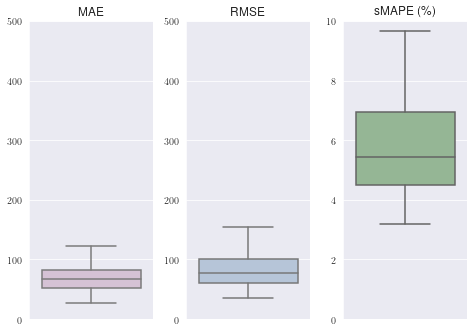

In [16]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
#plt.savefig('figures/emergencies_MLP_daily_type_boxplot.pdf')

In [19]:
emer_mlp_day_type = [mae,rmse,smape]
%store emer_mlp_day_type

Stored 'emer_mlp_day_type' (list)
